### Practicing data skills!
#### By Greg Glickert

In [16]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv("train.csv")
#data.dropna(inplace=True) # drop rows with NaN
data.dropna(axis=1, inplace=True) # drops columns with NaN might put this back later
y = data['Survived']
X = data.drop(['Survived','PassengerId','Name'], axis=1) # features df

X

,Pclass,Sex,SibSp,Parch,Ticket,Fare
0,3,male,1,0,A/5 21171,7.25
1,1,female,1,0,PC 17599,71.28
2,3,female,0,0,STON/O2. 3101282,7.92
3,1,female,1,0,113803,53.10
4,3,male,0,0,373450,8.05
...,...,...,...,...,...,...
886,2,male,0,0,211536,13.00
887,1,female,0,0,112053,30.00
888,3,female,1,2,W./C. 6607,23.45
889,1,male,0,0,111369,30.00


In [18]:
cols = X.columns
num_cols = X._get_numeric_data().columns  # Numeric columns
cat_cols = list(set(cols) - set(num_cols))  # Categorical columns

# Apply LabelEncoder to each categorical column
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

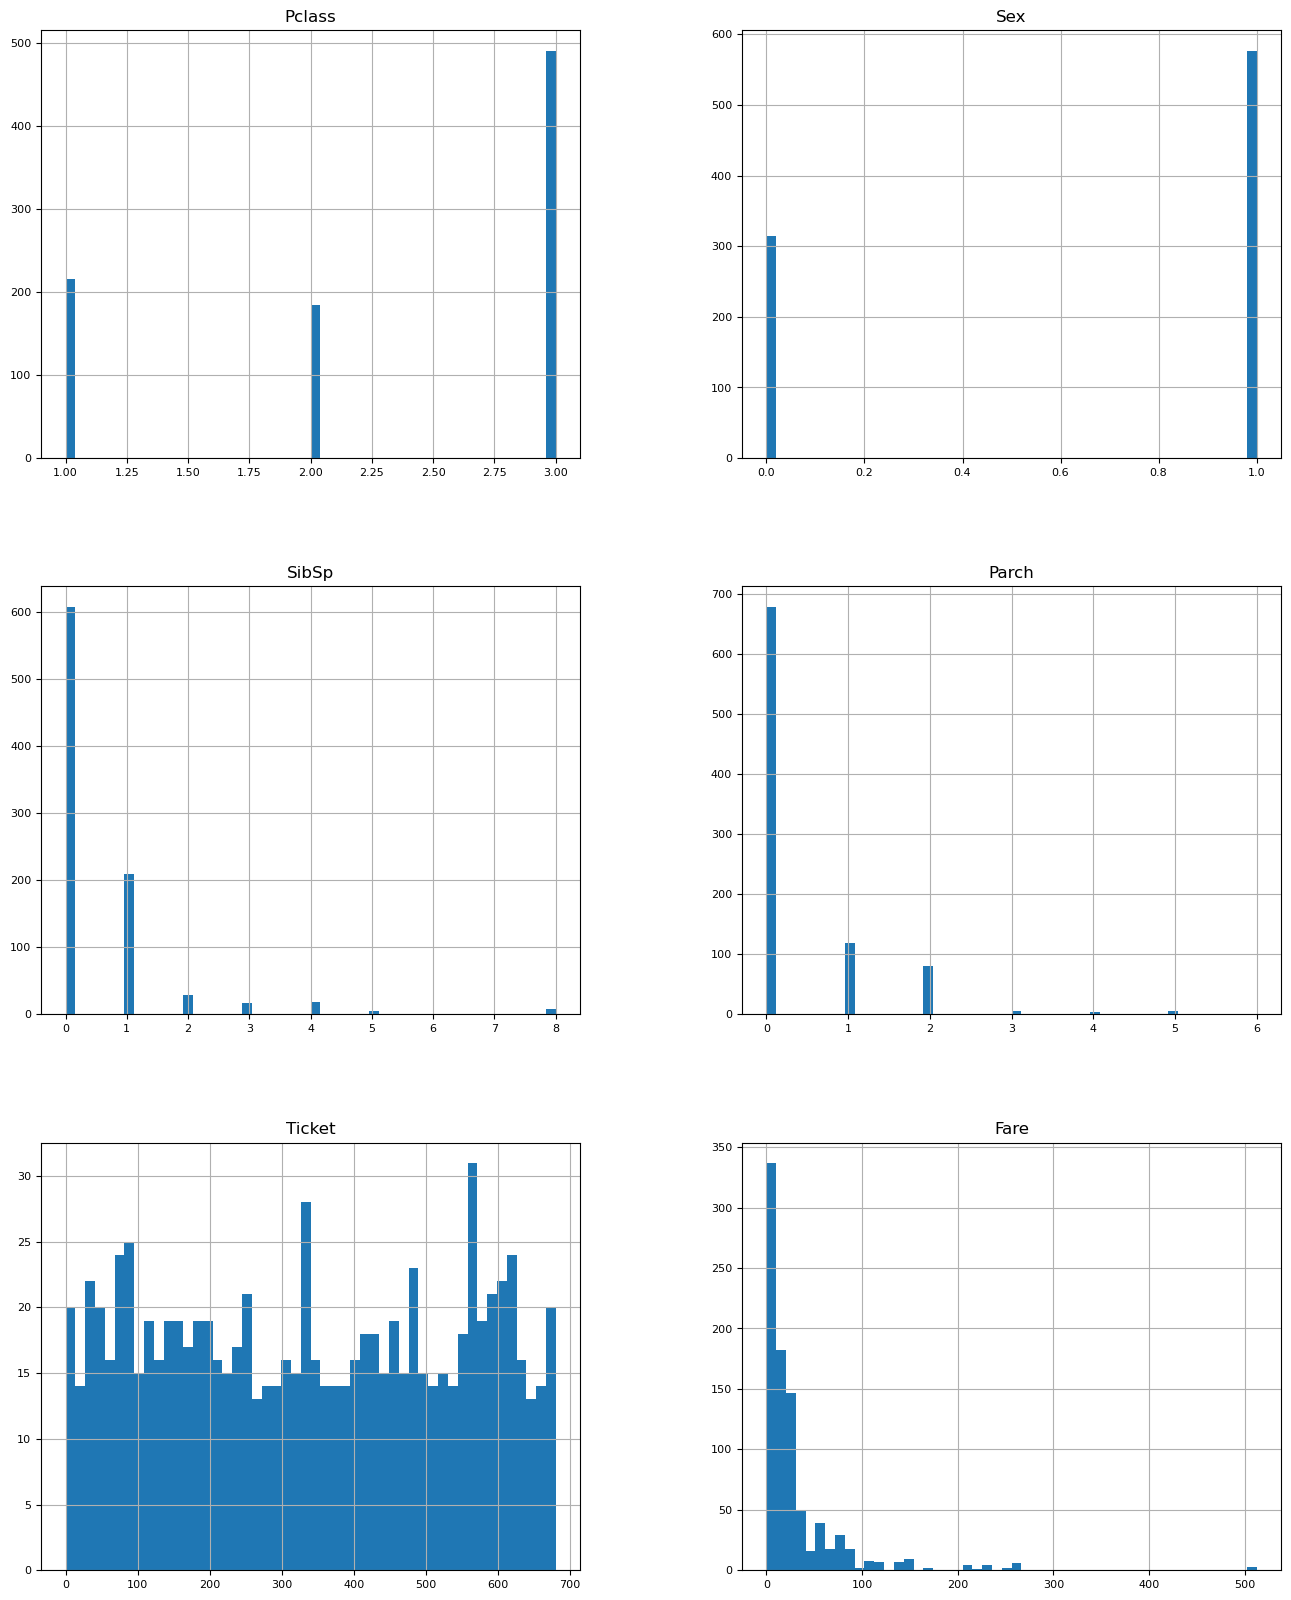

In [19]:
X.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [20]:
X = sm.add_constant(X)
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.456004
         Iterations 6


In [21]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      884
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Jan 2025   Pseudo R-squ.:                  0.3152
Time:                        14:57:42   Log-Likelihood:                -406.30
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.052e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2070      0.378      8.490      0.000       2.467       3.947
Pclass        -0.7375      0.136     -5.440      0.000      -1.003      -0.472
Sex           -2.7605      0.196    -14.050      0.0

In [22]:
d = {}
for i in X.columns.tolist():
    d[f'{i}'] = log_reg.pvalues[i]

df_pvalue= pd.DataFrame(d.items(), columns=['feature_name', 'p-Value']).sort_values(by = 'p-Value').reset_index(drop=True)
df_pvalue

,feature_name,p-Value
0,Sex,0.00
1,const,0.00
2,Pclass,0.00
3,SibSp,0.01
4,Ticket,0.04
5,Fare,0.07
6,Parch,0.38


### We can see feature with low p-values using the stat model library. 

### For Classification Models in SKlearn we can use the cross_val_score to get lots of different score metrics. We could then compare these metrics across different models to select the best one.

In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X,y)

results = []
names = []
for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(model, X, y, scoring=score, cv=10).mean()
    print(score + " : "+ str(cvs))
    

roc_auc : 0.838009648303766
f1 : 0.7162010325825193
precision : 0.7654321753515301
recall : 0.6784033613445379
accuracy : 0.7957303370786517


### We could manually check a bunch of different sklearn models or we could just use this fun package!

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)
clf = LazyClassifier(verbose=False,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/31 [00:00<?, ?it/s]

 81%|████████  | 25/31 [00:01<00:00, 12.93it/s]

### We now get a rough idea of how all the different models work. Note some of these could have different parameters that would increase the score. This package should be more used for a starting point. We could explore the top 5 models and do further optimization 

### Now this may be overkill for this example but lets try a neural network

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [11]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Create a Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# simple model that i came up with. Could be better

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First layer with 128 units
        self.fc2 = nn.Linear(128, num_classes)  # Output layer with 'num_classes' units
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [13]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X.shape[1]  # Number of input features
num_classes = 2 #cause its binary
model = SimpleNN(input_size, num_classes).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss() # really for multiclass but works fine for our case and dont need sigmoid then
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
from tqdm.notebook import tqdm 
# Training loop
num_epochs = 101
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        
        # send to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs).squeeze()
        
        # Compute the los
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print statistics for the epoch
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epochs:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch [1/101], Loss: 0.6191, Accuracy: 74.52%
Epoch [11/101], Loss: 0.5260, Accuracy: 77.78%
Epoch [21/101], Loss: 0.6416, Accuracy: 74.75%
Epoch [31/101], Loss: 0.4961, Accuracy: 78.00%
Epoch [41/101], Loss: 0.4591, Accuracy: 80.70%
Epoch [51/101], Loss: 0.8738, Accuracy: 69.70%
Epoch [61/101], Loss: 0.6618, Accuracy: 75.31%
Epoch [71/101], Loss: 0.5300, Accuracy: 78.45%
Epoch [81/101], Loss: 0.4775, Accuracy: 79.57%
Epoch [91/101], Loss: 0.4854, Accuracy: 78.68%
Epoch [101/101], Loss: 0.5863, Accuracy: 76.99%
